# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:

<center>
    
|idx    | frame size (B) |  time (s)  |
| -----------------| ---------------|-----|
|0      | 38424          |  0.0       |
|1      | 39801          |  0.01944   |
| ...   | ...            | ...        |

</center>

The game was run at 60 frames per second, with a target rate of 30 Mb/s. **The task is then to predict the size of the next frame, given the past N frames.** This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [11]:
import numpy as np
import numpy.random as npr
import pandas as pd
import random as rnd
import scipy.linalg as la
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

npr.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')
data.shape

(34507,)

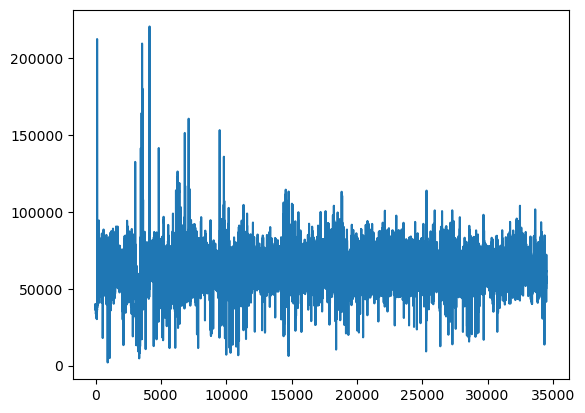

In [15]:
plt.plot(data)

## Prepare the data and create training and test sets

In this case, we are learning a time series: **let us consider a memory of 2 samples**, i.e., use X[n-1] and X[n-2] to predict X[n].

In [10]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size            # so now the mean is 1

# Compute the splits and prepare the columns (75% for training set, 25% for test set)
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])           # matrix of three columns, the first filled with 1's (for bias term)
X_training[:,1] = norm_data[: m_training - 2]       # second column filled with frame size data from 0 to tot-2
X_training[:,2] = norm_data[1 : m_training - 1]     # third column filled with frame size data from 1 to tot-1
Y_training = norm_data[2 : m_training]              # prediction array is filled with frame size data from 2 to tot
# in this way each row of X has different time step of frames, useful for make predictions:
    # row of X : 1, X(t-2), X(t-1)           row of Y :   X(t)

# similarly:
X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [13]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray):
    ## Run the LS algorithm without regularization
    XT = np.transpose(X_matrix)
    A = np.dot( XT, X_matrix )
    b = np.dot( XT, labels )
    A_inv = la.inv(A)
    w = np.dot( A_inv, b)
    return w
    

def evaluate_model(x, y, coeff):
    ## Return the average MSE for the set over which we evaluate
    m = len(x)
    y_pred = np.dot( x,coeff )
    mse_vector = (y - y_pred)**2
    mse = np.sum(mse_vector)/m
    return mse

In [18]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)       # mse renormalized to the average

Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.354721539141


To me it doesn't seem a good result...

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_47432/403805425.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel(f"$ \lambda $")


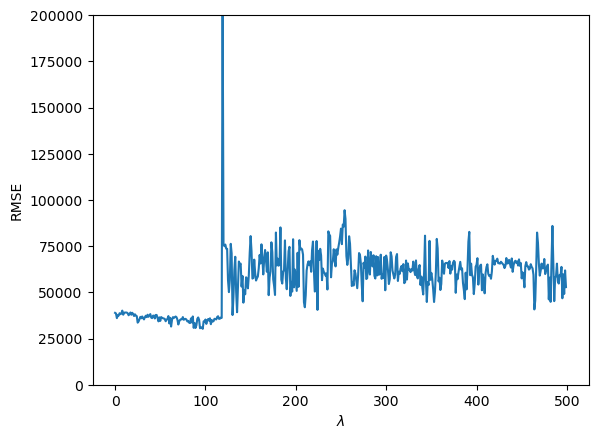

In [43]:
m=500
plt.plot(range(m), Y_training[:m] * avg_size)
plt.xlabel(f"$ \lambda $")
plt.ylabel(f'RMSE')
plt.ylim([0, 200000])
plt.show()

Here we can see that there are many outliers that increase the mse

---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

Flusso della validazione:
* Dividi i dati in k fold.
* Per ogni valore di $\lambda$, e per ogni fold (da 0 a k):
    * Allena il modello (=fai least squares) con i dati dei k-1 fold.
    * Valida il modello con il fold rimanente calcolando l'errore (mse) tra le previsioni e i dati reali del fold di validazione.
* Per ogni valore di $\lambda$ calcola la media degli errori (mean_mse) su tutti i fold.
* Alla fine, il valore di $\lambda$ che ha il miglior errore medio (ad esempio, il più basso) è scelto come il miglior modello e viene ri-allenato stavolte sull'interezza dei dati (senza fare fold)

In [36]:
# Least squares solution with tikhonov
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray):
    ## Run the LS algorithm with regularization
    m = X_matrix.shape[0]
    XT = np.transpose(X_matrix)
    A = np.dot( XT, X_matrix )
    b = np.dot( XT, labels )
    Id = np.eye(A.shape[0])
    inv = la.inv(lambda_par*Id + A)          # professor used this formula, but shouldn't it be ' 2*lambda_par*m*Id + A ' ?
    w = np.dot( inv, b)
    return w

## Perform K-fold cross-validation:
def K_fold(X_matrix: np.ndarray, labels: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray):
    
    # Divide training set in K folds:
    m = len(X_training)                     # num totale dati
    tot_idx = np.arange(m)                  # all indexes from 0 to m
    npr.shuffle(tot_idx)                    # mix of indexes
    idx_folds = np.array_split(tot_idx, K)  # we create K folds of mixed indexes

    # Train and validate:
    results=[]        # list of mse for each value of lambda
    best_mse=10**10   # mean mse used for searching best model
    best_coeff=[]     # list of best results
    models=[]         # list of coefficients for each lambda
    for lam in lambda_vec:
        mse_tot = 0
        models.append(regularized_least_squares(X_matrix, labels, lam))
        for i_k in range(K):
            x_i_train = np.concatenate( [ X_matrix[idx_folds[i_fold]] for i_fold in range(K) if i_fold != i_k ] )
            y_i_train = np.concatenate( [   labels[idx_folds[i_fold]] for i_fold in range(K) if i_fold != i_k ] )
            x_i_valid = X_matrix[idx_folds[i_k]]
            y_i_valid =   labels[idx_folds[i_k]]
            # training:
            coeff = regularized_least_squares(x_i_train, y_i_train, lam)
            # validation:
            mse_tot += evaluate_model(x_i_valid, y_i_valid, coeff)
        mean_mse = mse_tot/K
        results.append(mean_mse)
        # if result is better than previous, we train it over all training set to obtain training error:
        if (mean_mse < best_mse):
            best_mse = mean_mse
            best_coeff = regularized_least_squares(X_matrix, labels, lam)    
    
    return best_coeff, best_mse, models, results

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_47432/1294695603.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


[0.3690709  0.20613828 0.42368733] 
 [0.02143770370566686, 0.0214376329359505, 0.02143757169642333, 0.021437519815079152, 0.021437477123239863, 0.021437443455483172, 0.021437418649572996, 0.021437402546391232, 0.021437394989870857, 0.02143739582693118, 0.021437404907414293, 0.021437422084023088, 0.021437447212260808, 0.021437480150372036, 0.02143752075928509, 0.021437568902555534, 0.02143762444631144, 0.02143768725919971, 0.021437757212333566, 0.021437834179241305, 0.021437918035816447, 0.021438008660268938, 0.021438105933077194, 0.021438209736941754, 0.021438319956739494, 0.021438436479479395, 0.021438559194258876, 0.02143868799222141, 0.021438822766514976, 0.021438963412251443, 0.02143910982646704, 0.021439261908083415, 0.021439419557870012, 0.02143958267840667, 0.021439751174047842, 0.021439924950886802, 0.021440103916721253, 0.021440287981019577, 0.021440477054887414, 0.02144067105103565, 0.021440869883748596, 0.021441073468853076, 0.021441281723688078, 0.02144149456707532, 0.02144

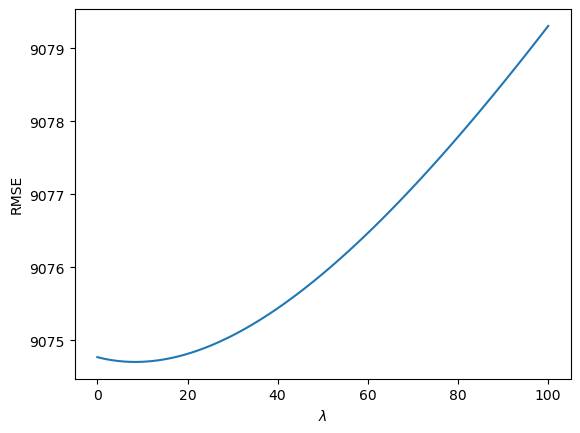

In [37]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(101)

best_coeff, best_mse, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_coeff, '\n' , results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


The result are worse than without tikhonov! This is because the outliers weight very much

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_47432/1799133235.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


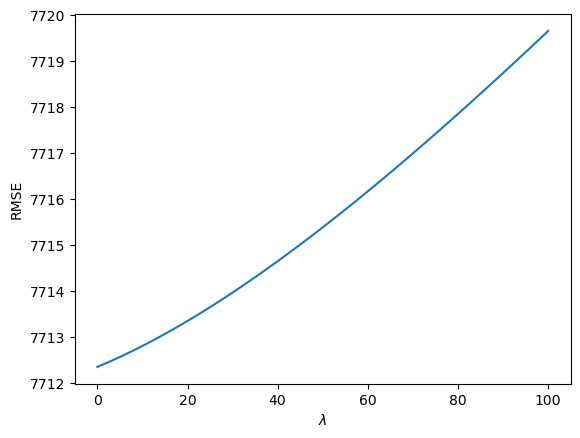

In [38]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


The errors in test set are better than in training set! This is again because f outliers

### EXTRA

Can you figure out the best amount of memory to use? I.e., can you figure out the best number of previuos data needed (X[n-1], X[n-2], X[n-3]...) to predict next frame?

Solution: see article mentioned above